# 1. When to use ML

Machine Learning can be a useful tool, but only when a few criteria are met first. In order for a machine to accurately categorize information, make future predictions, or solve a problem, it needs to be given data that it can actually use. 

This means that if we have a dataset that is flawed in some way, like if it isn’t in a format that can be properly read by the machine or if the data doesn’t really show anything useful, then trying to train a ML model on it wont give us good results. 

The model also needs to have a large enough dataset to be accurate. For example, if you build a ML model to categorize images, it will be more accurate if it's given 10 million data points as opposed to 10 thousand. If you aren’t able to get good enough data to solve the problem, then it's better not to use ML. 

Machine Learning is also really only useful if the problem would take too long to do manually or with traditional computing (ex. it's faster and easier to write this paragraph than to build an LLM that can write it). Even if you do have a usable data set, you still have to worry about being able to interpret and utilize the results. 

# 2. Pre-Processing

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

In [14]:
df = pd.read_csv('titanic.csv')
df.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


In [15]:
empty_count = df.isnull().sum()
empty_columns = empty_count[empty_count > 0]
empty_columns

Age         177
Cabin       687
Embarked      2
dtype: int64

The data is pretty much already standardized and "clean", but some things should be changed before we use it:

1. Some columns wont help us predict anything, so they can be removed 
    - 'Ticket' values arent helpful because they lack a pattern
  
    - 'PassengerId' and 'Name' aren't needed to make our predictions, they aren't correlated with anything
  
    -  'Cabin' has too little data to be reflect any relationship
  

3. Some columns have missing values: 'Age' and 'Embarked' 
    - all NaN values should be replaced with values that accurately reflect the distribution:
  
        - the median age should be used because mean is more affected by outliers, and mode doesn't make sense for ages
     
        - the mode of Embarked should be used because we just want the most common value
4. 'Sex' and 'Embarked' can be expressed as binary and ternary values respectively

5. Since 'SibSp' and 'Parch' both measure number of family members, it may be useful to combine them as 'nFamily'


In [16]:
#1.
df.drop(['Ticket', 'PassengerId', 'Name', 'Cabin'],axis=1, inplace=True)

#2.
df['Age'] = df['Age'].fillna(df['Age'].median())
df['Embarked'] = df['Embarked'].fillna(df['Embarked'].mode()[0])

#3.
s_map = {'male':0, 'female':1}
df['Sex'] = df['Sex'].map(s_map)
e_map = {'S':0, 'C':1, 'Q':2}
df['Embarked'] = df['Embarked'].map(e_map)

#4.
df['nFamily'] = df['SibSp'] + df['Parch']

df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,nFamily
0,0,3,0,22.0,1,0,7.2500,0,1
1,1,1,1,38.0,1,0,71.2833,1,1
2,1,3,1,26.0,0,0,7.9250,0,0
3,1,1,1,35.0,1,0,53.1000,0,1
4,0,3,0,35.0,0,0,8.0500,0,0


# 3. Correlation 

In [17]:
corr_matrix = df.corr()
corr_matrix

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,nFamily
Survived,1.000000,-0.338481,0.543351,-0.064910,-0.035322,0.081629,0.257307,0.106811,0.016639
Pclass,-0.338481,1.000000,-0.131900,-0.339898,0.083081,0.018443,-0.549500,0.045702,0.065997
Sex,0.543351,-0.131900,1.000000,-0.081163,0.114631,0.245489,0.182333,0.116569,0.200988
Age,-0.064910,-0.339898,-0.081163,1.000000,-0.233296,-0.172482,0.096688,-0.009165,-0.245619
SibSp,-0.035322,0.083081,0.114631,-0.233296,1.000000,0.414838,0.159651,-0.059961,0.890712
Parch,0.081629,0.018443,0.245489,-0.172482,0.414838,1.000000,0.216225,-0.078665,0.783111
Fare,0.257307,-0.549500,0.182333,0.096688,0.159651,0.216225,1.000000,0.062142,0.217138
Embarked,0.106811,0.045702,0.116569,-0.009165,-0.059961,-0.078665,0.062142,1.000000,-0.080281
nFamily,0.016639,0.065997,0.200988,-0.245619,0.890712,0.783111,0.217138,-0.080281,1.000000


<Axes: >

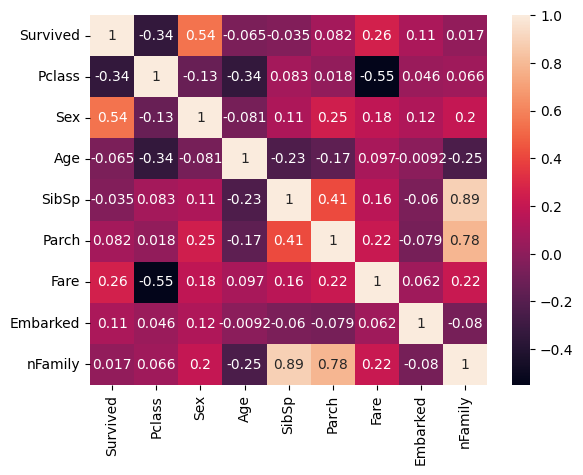

In [18]:
sns.heatmap(corr_matrix, annot=True)

The correlation matrix shows that the strongest predictors of survival are passenger sex, ticket class, and fare.

Sex had the strongest correlation to survival of any variable in the dataset at 0.54. It indicates that women had a higher rate of survival than men, which aligns with our knowledge that women were given priority during evacuation.

Ticket class (Pclass) had a relatively strong negative correlation with survival (-0.34), meaning that passengers in higher numbered classes had a lower rate of survival and vice versa.

Fare had a positive correlation with survival, but because of its association with ticket class (the higher class passengers paid more for their ticket).

The other relations are weak enough to consider negligible. 

# 4. Box Plot

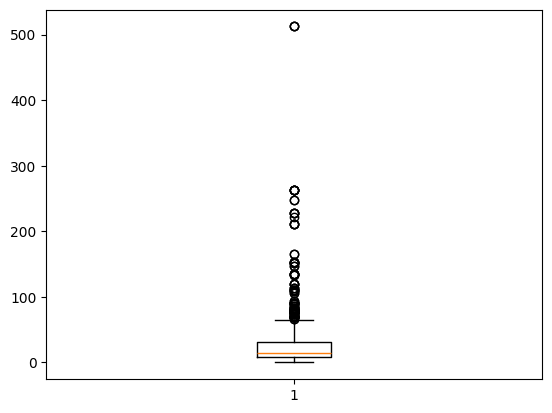

In [19]:
df['Fare'] = df['Fare'].fillna(df['Fare'].median())
boxplot = plt.boxplot(x=df['Fare'])

The null values are handled by replacing them with the median value. 

The plot shows that the majority of passengers spent approximately 70 or below, with a few outliers spending anywhere from 80 to 500+.

# 5. Age ranges

In [20]:
start_time = time.time()
labels = ['Child', 'Young Adult', 'Adult', 'Senior']
bins = [0, 16, 35, 60, 100]
df['age_bin'] = pd.cut(df['Age'], bins=bins, labels=labels)
cut_time = time.time() - start_time


start_time = time.time()
df['age_bin'] = df['Age'].apply(lambda age: 
                                  'Child' if age <= 16 else
                                  'Young Adult' if age <= 35 else
                                  'Adult' if age <= 60 else
                                  'Senior')
lambda_time = time.time() - start_time

print(f'cut method: {cut_time} seconds')
print(f'lambda method: {lambda_time} seconds')

df.head()

cut method: 0.0013439655303955078 seconds
lambda method: 0.00026488304138183594 seconds


,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,nFamily,age_bin
0,0,3,0,22.0,1,0,7.2500,0,1,Young Adult
1,1,1,1,38.0,1,0,71.2833,1,1,Adult
2,1,3,1,26.0,0,0,7.9250,0,0,Young Adult
3,1,1,1,35.0,1,0,53.1000,0,1,Young Adult
4,0,3,0,35.0,0,0,8.0500,0,0,Young Adult


The lambda function consistently finishes faster than the cut function.

# 6. Histograms

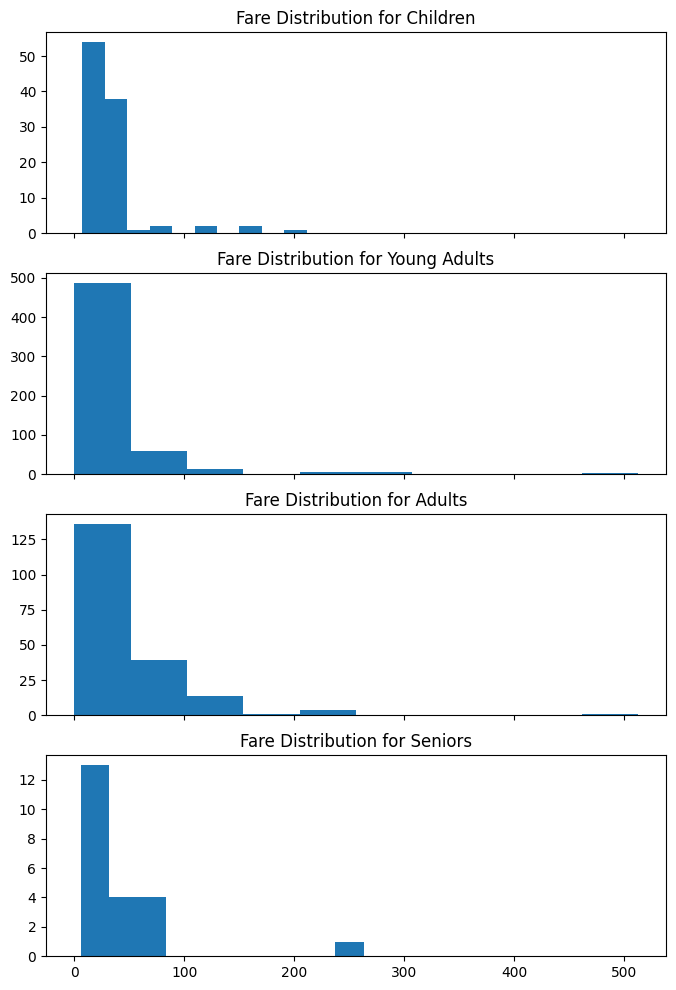

In [21]:
fig, axes = plt.subplots(len(labels), 1, figsize=(8, 12), sharex=True)

for i in range(len(labels)):
    group = labels[i] 
    axes[i].hist(df[df['age_bin'] == group]['Fare']) 
    if group == 'Child':
        axes[i].set_title(f'Fare Distribution for {group}ren') 
    else:
        axes[i].set_title(f'Fare Distribution for {group}s') 

Children largely had the cheapest fares, likely because of an age based discount. 

Young adults and adults had a similar distribution of fares, but a smaller amount young adults paid for more expensive fares.

There's a very small amount of seniors in the dataset, but for the most part they match with the Adult group.